In [1]:
import docx
from simplify_docx import simplify

In [2]:
# read in a document 
my_doc = docx.Document("Analysis_Fire_12_30_21_CBS.docx")

# coerce to JSON using the standard options
my_doc_as_json = simplify(my_doc)

In [3]:
import pandas as pd
pd.options.display.max_rows = 500

In [4]:
# my_doc_as_json

import json
with open('cbs2.json', 'w') as fp:
    json.dump(my_doc_as_json, fp)

In [5]:
# create a list of dicts(time, location, station, text)
clean_data = []

for blob in my_doc_as_json['VALUE'][0]['VALUE'][2:]:
    text_end = False
    count = 0
    key = f'text{count}'
    
    if blob['TYPE'] == 'table':
        time = blob['VALUE'][0]['VALUE'][0]['VALUE'][0]['VALUE'][0]['VALUE']
        location = blob['VALUE'][0]['VALUE'][1]['VALUE'][0]['VALUE'][0]['VALUE']
        station = blob['VALUE'][0]['VALUE'][2]['VALUE'][0]['VALUE'][0]['VALUE']
        
        # print(time, location, station)

    if blob['TYPE'] == 'paragraph':
        text = blob['VALUE'][0]['VALUE']
        text_end = True
        
    if text_end:
        clean_data.append({
            "time": time,
            "location": location,
            "station": station,
            "text": text
        })
        count += 1

        
print('done')
    

done


In [6]:
# create dataframe
cbs_df = pd.DataFrame.from_dict(clean_data)

In [7]:
cbs_df['text'] = cbs_df['text'].str.lower()

In [8]:
cbs_df.head()

,time,location,station,text
0,2021-12-30 6:49 PM,Phoenix (Prescott),KPHO,"have been destroyed. ap, the associated press ..."
1,2021-12-30 6:48 PM,Phoenix (Prescott),KPHO,"kusa, the nbc affiliate in denver, this is in ..."
2,2021-12-30 6:37 PM,Ft. Myers-Naples,WINK,several communities were evacuated because of ...
3,2021-12-30 6:37 PM,Greensboro-H.Point-W.Salem,WFMY,the evening ending overnight. several communit...
4,21-12-30 6:37 PM,Atlanta,WGCL,the evening ending overnight. several communit...


In [9]:
from words import CLIMATE_CHANGE_RELATED_WORDS

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

from wordcloud import STOPWORDS

final_stopwords = list(STOPWORDS) + list(stop_words)
final_stopwords = set(final_stopwords)

[nltk_data] Downloading package stopwords to /Users/loren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# remove duplicates
from thefuzz import fuzz

def duplicate_check(text):
    matches = cbs_df.apply(lambda row: (fuzz.partial_ratio(row['text'], text) >= 85), axis=1)
    return [i for i, x in enumerate(matches) if x]


cbs_df['matches'] = cbs_df.apply(lambda row: duplicate_check(row['text']), axis=1)

In [11]:
#cbs_df[cbs_df['use_row'].isnull()]


def fetch_biggest_text(idx_list):
    biggest_length = 0
    idx = None
    
    if len(idx_list) == 1:
        return idx_list[0]
    
    for i in idx_list:
        current_length = len(cbs_df['text'][i])
        if current_length > biggest_length:
            biggest_length = current_length
            idx = i
    return idx

fetch_biggest_text(cbs_df['matches'][2])

14

In [12]:
cbs_df['row_to_use'] = cbs_df.apply(lambda row: fetch_biggest_text(row['matches']), axis=1)

In [13]:
# cbs_df.loc[cbs_df['matches'].str.len() == 1, 'use_row'] = True 
# cbs_df['use_row']

idxs = list(cbs_df['row_to_use'].unique())

for index, row in cbs_df.iterrows():
    # print(index in idxs)
    cbs_df.at[index,'use_row'] = index in idxs
    
# getting unique:
# get the first value in the matches list if len is 1
# else for duplicates, get the longest text, grab that index

In [14]:
no_dup_cbs_df = cbs_df[cbs_df['use_row']]
no_dup_cbs_df

,time,location,station,text,matches,row_to_use,use_row
0,2021-12-30 6:49 PM,Phoenix (Prescott),KPHO,"have been destroyed. ap, the associated press ...",[0],0,True
1,2021-12-30 6:48 PM,Phoenix (Prescott),KPHO,"kusa, the nbc affiliate in denver, this is in ...",[1],1,True
14,2021-12-30 6:37 PM,"Portland, OR",KOIN,the rain will continue through the evening end...,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",14,True
38,2021-12-30 6:12 PM,Sacramnto-Stkton-Modesto,KOVR,tracking the devastating fires in colorado and...,[38],38,True
39,2021-12-30 6:20 PM,Sacramnto-Stkton-Modesto,KOVR,here we have evacuations. i will tell you a li...,[39],39,True
41,2021-12-30 6:00 PM,Sacramnto-Stkton-Modesto,KOVR,about. we just talked about the hospital where...,[41],41,True
42,2021-12-30 5:59 PM,Sacramnto-Stkton-Modesto,KOV,"together. this house, burning to the ground. 3...",[42],42,True
43,2021-12-30 5:55 PM,Ft. Myers-Naples,WINK,"rubenstein law, injured in a car accident or s...",[43],43,True
44,2021-12-30 5:44 PM,Baltimore,WJZ,e2021-12-30 5:44 pm,[44],44,True
45,2021-12-30 5:44 PM,Baltimore,WJZ,wildfire-that engulfed parts of the area. in a...,"[45, 46]",45,True


In [15]:
# breakdown words - unique words only
no_dup_cbs_df['words'] = no_dup_cbs_df['text'].str.lower().str.replace(',', '').str.replace('>','').str.replace('.','').str.replace('\n','').str.replace('’',"'").str.replace('!','').str.replace('?','').str.replace('%','').str.replace(')','').str.replace('(','').str.replace('_','').str.replace(':','').str.strip().str.split(' ')

def clean_text(words):
    # text.replace(',', '').replace('>','').replace('.','').replace('\n','').replace('’',"'").replace('!','').replace('?','').replace('%','').replace(')','').replace('(','').replace('_','').replace(':','')
    # words = text.split(' ')
    
    for word in words:
        if word.isdigit():
            words.pop(words.index(word))
    
    return words


no_dup_cbs_df.apply(lambda row: clean_text(row['words']), axis=1)

/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0     [have, been, destroyed, ap, the, associated, p...
1     [kusa, the, nbc, affiliate, in, denver, this, ...
14    [the, rain, will, continue, through, the, even...
38    [tracking, the, devastating, fires, in, colora...
39    [here, we, have, evacuations, i, will, tell, y...
41    [about, we, just, talked, about, the, hospital...
42    [together, this, house, burning, to, the, grou...
43    [rubenstein, law, injured, in, a, car, acciden...
44                                    [e2021-12-30, pm]
45    [wildfire-that, engulfed, parts, of, the, area...
47    [outside, of, denver, have, been, told, to, ev...
65    [they, are, calling, this, now, the, marshall-...
66    [signatures, here, this, is, where, we, have, ...
67    [sun, morning, satellite, imagery, right, now,...
68    [to, breaking, news, now, this, is, a, live, l...
69    [thousands, of, people, have, been, ordered, t...
71    [into, the, central, rockies, and, it, is, a, ...
72    [we, couple, that, with, relative, humidit

In [16]:
# compile the list of unique words, get that count
total_words = no_dup_cbs_df['words'].str.len().sum()
total_words

2757

In [17]:
unique_words_found = set()
for chunk in no_dup_cbs_df['words']:
    for word in chunk:
        unique_words_found.add(word)

total_unique_words =  len(unique_words_found)
total_unique_words

823

In [18]:
# run lemmatization clean
# tokenize filtered word list for frequency distribution
from nltk.tokenize import word_tokenize
nltk.download('punkt')

#Lexicon Normalization
# Lemmatization -- distill to root words

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

lemma_list = []
for word, tag in nltk.pos_tag(unique_words_found):
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
        lemma = word
    else:
        lemma = lem.lemmatize(word, pos=wntag)
    lemma_list.append(lemma)
len(lemma_list)

[nltk_data] Downloading package punkt to /Users/loren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/loren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/loren/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/loren/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


823

<FreqDist with 633 samples and 706 outcomes>


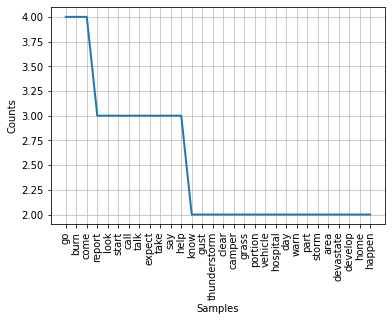

In [19]:
from nltk.probability import FreqDist
# no stopwords
clean_lemma_list = []

for word in lemma_list:
    if word not in final_stopwords:
        clean_lemma_list.append(word)
len(clean_lemma_list)
        

# graph frequence distributions of lemma words
lfdist = FreqDist(clean_lemma_list)
print(lfdist)

import matplotlib.pyplot as plt
lfdist.plot(30,cumulative=False)
plt.show()

In [20]:
# lfdist
len(clean_lemma_list)

706

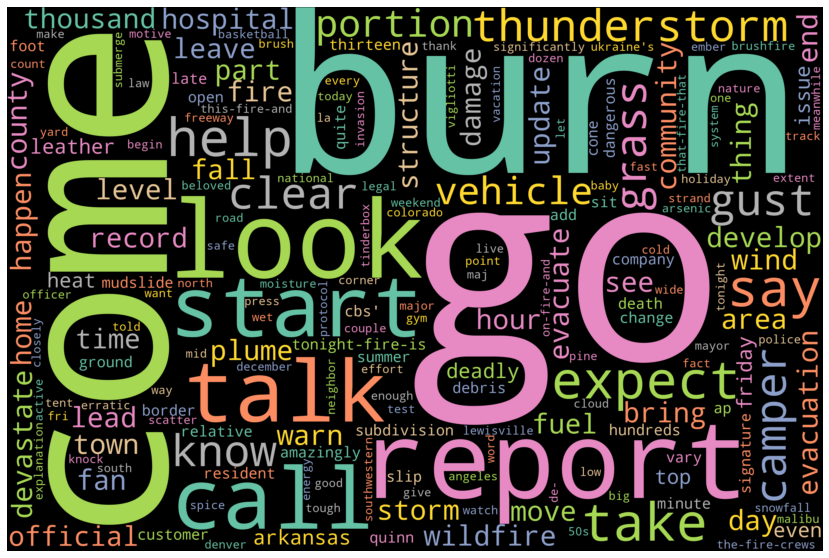

In [21]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = final_stopwords).generate_from_frequencies(lfdist)

# Plot
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#plt.savefig('word_cloud.png')

                     counts
Words                      
Climate-related           8
Non Climate-related     698


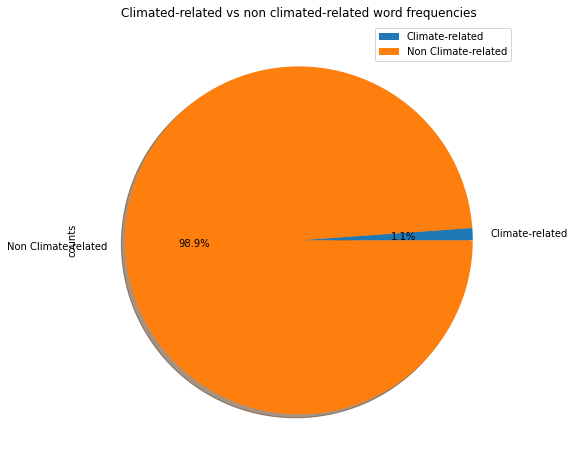

In [22]:
import pandas as pd
pd.options.display.max_rows = 500
words_df = pd.DataFrame(lfdist.items(), columns=['Word', 'Count'])

words_df.sort_values(by=['Count'], ascending=False, inplace=True)
len(words_df)
# 1374 total words

words_df['Count'].sum()

# create data
climate_change_words_df = words_df.loc[words_df['Word'].isin(CLIMATE_CHANGE_RELATED_WORDS)]

climate_words_count = climate_change_words_df['Count'].sum()
non_climate_words_count = words_df['Count'].sum() - climate_words_count

comparison_df = pd.DataFrame({'Words': ['Climate-related', 'Non Climate-related'],
                             'counts': [climate_words_count, non_climate_words_count]})
comparison_df.set_index('Words', inplace=True)
print(comparison_df)

plot = comparison_df.plot.pie(y='counts', title="Climated-related vs non climated-related word frequencies", legend=True, autopct='%1.1f%%', shadow=True, figsize=(8, 8))

fig = plot.get_figure()
fig.savefig("comparison.png")

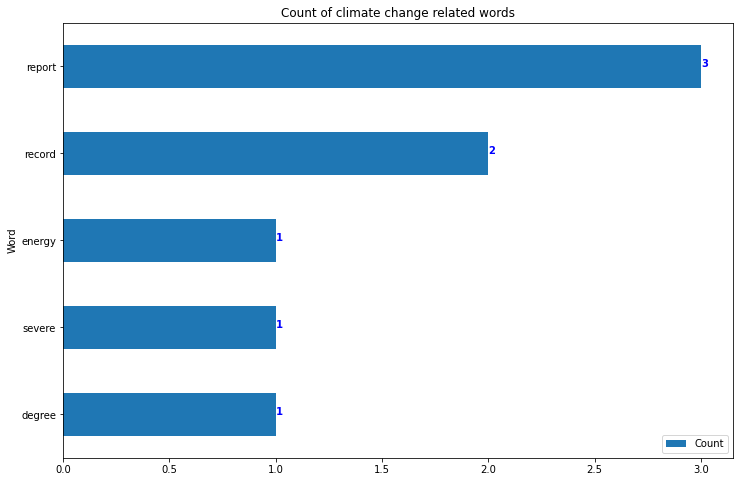

In [23]:
# find climate related word frequencies

# set figure size
fig, ax = plt.subplots(figsize=(12, 8))
# plot horizontal bar plot
climate_change_words_df.sort_values(by='Count').plot.barh(x="Word", y="Count", ax=ax)
# set the title
plt.title("Count of climate change related words")

for i, v in enumerate(climate_change_words_df['Count'].sort_values()):
    ax.text(v, i , str(v),
            color = 'blue', fontweight = 'bold')

plt.show()
# plt.savefig('climate-related-words-breakdown.png', transparent=False)

In [24]:
# find segments

climate_change_words_found = list(climate_change_words_df['Word'].unique())
climate_change_words_found
    
climate_change_words_found_str = '(?i)|'.join(climate_change_words_found)
climate_change_words_found_str = '(?i)' + climate_change_words_found_str
climate_change_words_found_str

'(?i)report(?i)|record(?i)|degree(?i)|severe(?i)|energy'

In [25]:
pd.set_option("display.max_colwidth", -1)

/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [26]:
no_dup_cbs_df['text'] = no_dup_cbs_df['text'].str.lower()

/Users/loren/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
climate_change_related_df =  no_dup_cbs_df[no_dup_cbs_df['text'].str.lower().str.contains(climate_change_words_found_str)]
climate_change_related_df.loc[:, 'time':'text']

,time,location,station,text
0,2021-12-30 6:49 PM,Phoenix (Prescott),KPHO,"have been destroyed. ap, the associated press is reporting the number at 580 homes. there are no deaths or injuries reported yet, but the evacuations happened so fast, they believe that people were caught unfortunately in this fast moving brushfire. again, let me give you the location of this-fire-and what has changed within the last 20 minutes. denver, colorado, i-25, i-70. this, to you and me looks like rain and snow. it's not. this is the smoke plume from the fires. remember how we can measure on radar the smoke plumes on our big fires. this is a smoke plume. here's the fire, northwest of denver, look how long the smoke plume is stretching, 92 miles. this is a big national story developing right in front of us here. there's denver, superior, the town that was evacuated, that's roughly 18 miles and the fire"
1,2021-12-30 6:48 PM,Phoenix (Prescott),KPHO,"kusa, the nbc affiliate in denver, this is in jefferson and boulder counties, these are areas and communities northwest of denver, roughly about 20 miles northwest of denver. what has happened up there is the weather turned pretty windy. when i say pretty windy, wind gusts 80 to 100 miles an hour. this is the foothills area of colorado. not up in the rockies. it's the very wide ranging grasslands. what happened was they believe winds knocked down power lines, caught the grasses on-fire-and it's been amazingly dry up there all november and much of december, and being if, this went off like a tinderbox. it's grown to 1600 acres. we've had two towns evacuated and we're now getting reports from the sheriff's departments of jefferson and boulder counties that hundreds of homes"
14,2021-12-30 6:37 PM,"Portland, OR",KOIN,"the rain will continue through the evening ending overnight. several communities were evacuated because of flooding like this, and the risk of mudslides, major. >> garrett: jonathan vigliotti, thank you. so, what's next? we turn to cbs' lonnie quinn with the forecast. lonnie, good evening. >> reporter: good evening to you, major.u, maj toughest weather anywhere in the country in colorado today. the strongest wind gust 115 miles per hour. currently the winds are gusting around 60 miles an hour, down to the 50s, 40 miles per hour through the overnight hours. still it's really hard to fight any-fire-burning out there and no help from mother nature. more wind than rain. where the rain is falling from georgia to south carolina, severe thunderstorm threat for that area until 9:00 p.m. what about new year's eve? new year's eve, i'm going to focus from nashville to memphis, over to arkansas. new year's eve, that's where you have a risk for severe weather. all the while into nears day, snowfall anywhere from kansas city through portions of the great lakes, detroit is cold as"
41,2021-12-30 6:00 PM,Sacramnto-Stkton-Modesto,KOVR,"about. we just talked about the hospital where the evacuation happened. you can see, this is the hospital right here in these red spots behind it is where we >> the shopping center right here, there is a target store, and there are reports that the target store is gone as well as a hotel and shopping center and you see all of these homes around here and these were on fire. the mayor of superior, he has been quoted as saying, our town is burning around us, and the sheriff their reporting a very dire situation as the fire burns into the night. but there is a winter storm warning going into effect tomorrow morning and we could have 5 to 10 inches of snow in this area by saturday. >>> here at home after spending days in the dark, power is back"
45,2021-12-30 5:44 PM,Baltimore,WJZ,"wildfire-that engulfed parts of the area. in all, more than 30,000 people have been told to get to safety. gusty winds are fueling the massive fires which comes after the official and to wildfire season. so far, no one has been hurt. >>> police in north carolina are looking for the gunman who opened-fire-

In [272]:
# import difflib

# #cbs_df['duplicate'] = cbs_df['text'].eq(cbs_df['text'].shift())
# #difflib.get_close_matches(cbs_df['text'][0], cbs_df['text'])

# texts = ['dog', 'cat', 'mad cat', 'good dog', 'bad dog', 'chicken']
# fuzz.ratio('dog', texts)


# for i, value in enumerate(texts):
#     print('**', value)
#     print(i)
#     new_list = texts[i+1:] + texts[:i]
#     print(new_list)
    
#     for word in new_list:
#         ratio = fuzz.partial_ratio(value, word)
#         if ratio >= 85:
#             print(ratio, value, word)